In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("szrlee/stock-time-series-20050101-to-20171231")

print("Path to dataset files:", path)

100%|██████████| 3.03M/3.03M [00:00<00:00, 107MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/szrlee/stock-time-series-20050101-to-20171231/versions/3


In [6]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [7]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [8]:
# First, we get the data
# Load the CSV and ensure 'Date' is parsed and set as index
dataset = pd.read_csv(
    '/root/.cache/kagglehub/datasets/szrlee/stock-time-series-20050101-to-20171231/versions/3/IBM_2006-01-01_to_2018-01-01.csv',
    parse_dates=['Date'],
    index_col='Date'
)

dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [9]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

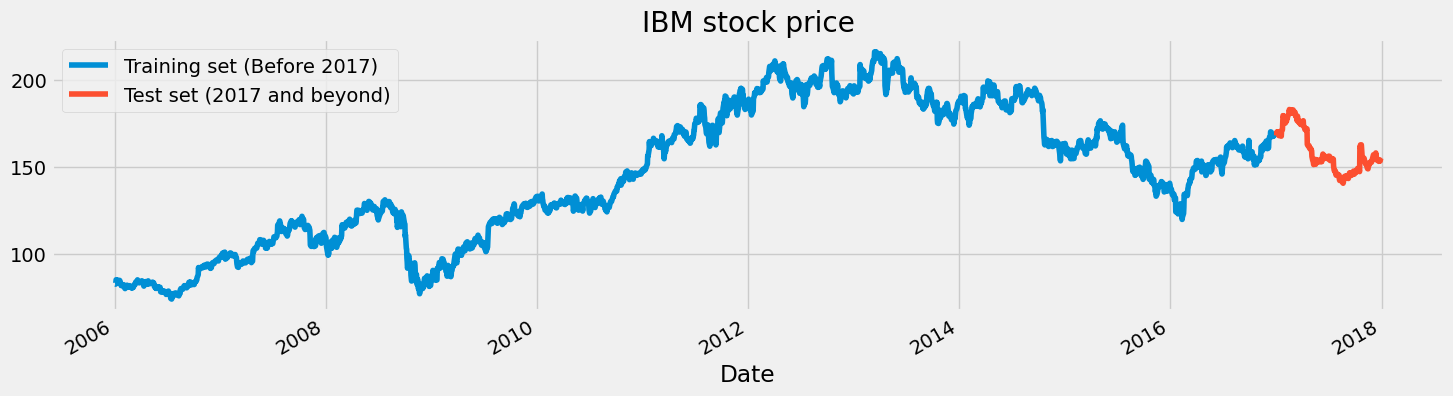

In [10]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()


In [11]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [12]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [14]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
print("Eager mode:", tf.executing_eagerly())  # Should now print True


Eager mode: True


In [16]:


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input

# Ensure eager execution is enabled
tf.config.run_functions_eagerly(True)

# LSTM model architecture
regressor = Sequential()
regressor.add(Input(shape=(X_train.shape[1], 1)))  # Explicit input
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

# Compile and fit
# removed run_eagerly=True to fix the error
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=1, batch_size=32)

85/85 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - loss: 0.0364


In [17]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [18]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 943ms/step


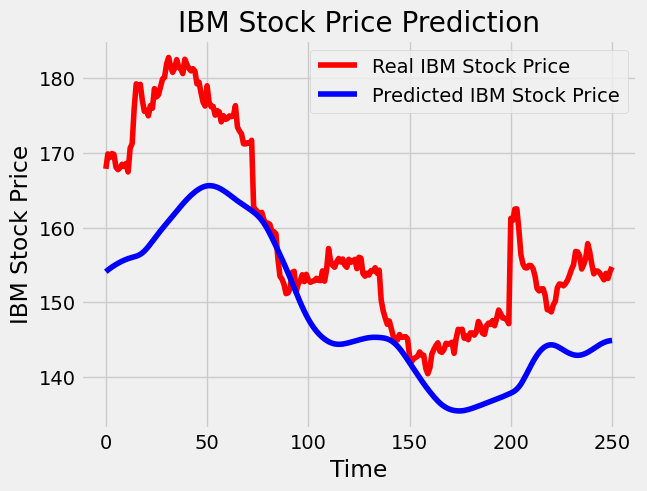

In [19]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [20]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 11.396197499644252.
